## Vamos a extrer la información de los diferentes datasets de amazon 

In [1]:
import json
import pandas as pd
from glob import glob


def convert(x):
    ''' Convert a json string to a flat python dictionary
    which can be passed into Pandas. '''
    ob = json.loads(x)
    for k, v in ob.items():
        if isinstance(v, list):
            ob[k] = ','.join(str(v))
        elif isinstance(v, dict):
            for kk, vv in v.items():
                ob['%s_%s' % (k, kk)] = vv
            del ob[k]
    return ob


In [2]:
# Hay que igualar y coger muestras de tamaño similar para todas las valoraciones?

## 2.-  Procesamiento de texto sobre las reviews
Eliminamos stopwords (TF-idf)<br/>
aplicamos métodos de lematizacion - TextBlob, NLTK <br/>
extraemos entidades (tokens)</br>


In [3]:
from textblob import TextBlob
from textblob import Word
import nltk
# nltk.download() hay que hacerlo la primera vez para cargar todos los corpus necesarios


## funcion que elimina las stopwords y aplica lematizacion

In [5]:
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")
cachedStopWords


[u'i',
 u'me',
 u'my',
 u'myself',
 u'we',
 u'our',
 u'ours',
 u'ourselves',
 u'you',
 u'your',
 u'yours',
 u'yourself',
 u'yourselves',
 u'he',
 u'him',
 u'his',
 u'himself',
 u'she',
 u'her',
 u'hers',
 u'herself',
 u'it',
 u'its',
 u'itself',
 u'they',
 u'them',
 u'their',
 u'theirs',
 u'themselves',
 u'what',
 u'which',
 u'who',
 u'whom',
 u'this',
 u'that',
 u'these',
 u'those',
 u'am',
 u'is',
 u'are',
 u'was',
 u'were',
 u'be',
 u'been',
 u'being',
 u'have',
 u'has',
 u'had',
 u'having',
 u'do',
 u'does',
 u'did',
 u'doing',
 u'a',
 u'an',
 u'the',
 u'and',
 u'but',
 u'if',
 u'or',
 u'because',
 u'as',
 u'until',
 u'while',
 u'of',
 u'at',
 u'by',
 u'for',
 u'with',
 u'about',
 u'against',
 u'between',
 u'into',
 u'through',
 u'during',
 u'before',
 u'after',
 u'above',
 u'below',
 u'to',
 u'from',
 u'up',
 u'down',
 u'in',
 u'out',
 u'on',
 u'off',
 u'over',
 u'under',
 u'again',
 u'further',
 u'then',
 u'once',
 u'here',
 u'there',
 u'when',
 u'where',
 u'why',
 u'how',
 u'all

In [32]:
import string
def remove_punctuation(text):  
    #salida = text.translate(None, string.punctuation).lower()
    salida = text.translate(None, string.punctuation)
    return salida

def lemmatizeReviewText(row):
    words = TextBlob(row).words.lemmatize()
    ext = ' '.join(word for word in words if word not in (cachedStopWords))
    return ext

In [35]:
#Tratamos el dataset de Babies review
babyDf = pd.DataFrame([convert(line) for line in file('reviews_Baby_5.json')])
# forzamos la columna reviewText como str para el correcto funcionamiento de remove_punctuation
babyDf['reviewText'] = babyDf['reviewText'].astype(str)
babyDf['review_clean'] = babyDf['reviewText'].apply(remove_punctuation)
babyDf['review_clean']=babyDf['review_clean'].apply(lambda x: x.lower())
babyDf['review_clean']= babyDf['review_clean'].apply(lemmatizeReviewText)

babyDf.to_csv('reviews_Baby_5.csv', header=True,quoting=1)


In [36]:
# Tratamos el dataset de Pets review
petsDf = pd.DataFrame([convert(line) for line in file('reviews_Pet_Supplies_5.json')])
# forzamos la columna reviewText como str para el correcto funcionamiento de remove_punctuation
petsDf['reviewText'] = petsDf['reviewText'].astype(str)
petsDf['review_clean'] = petsDf['reviewText'].apply(remove_punctuation)
petsDf['review_clean']= petsDf['review_clean'].apply(lambda x: x.lower())
petsDf['review_clean']= petsDf['review_clean'].apply(lemmatizeReviewText)
petsDf.to_csv('reviews_Pet_Supplies_5.csv', header=True,quoting=1)

# Generamos el dataframe amazonReviewsDf a partir de los dataframes  petsDf y babyDf

In [37]:
principalDf = [babyDf,petsDf]
amazonReviewsDf = pd.concat(principalDf)
# renombramos la columna overall por review_overall
amazonReviewsDf['review_overall']=amazonReviewsDf['overall']
del(amazonReviewsDf['overall'])
len(amazonReviewsDf)

318628

# Convertimos el dataFrame al csv que sera la fuente de entrada al modelo de ML

In [38]:
amazonReviewsDf.to_csv('babies+pets_reviews.csv', header=True,quoting=1)

In [39]:
# comprobamos que está bien generado el csv volviendolo a cargar en el DF
amazonReviewsDf=pd.read_csv('babies+pets_reviews.csv',header=False,sep=',')
len(amazonReviewsDf)



318628

In [40]:
#  crear un diccionario {palabra:ocurrencias}
num_important_words = 1500
import numpy as np
cnt = {}
for linea in amazonReviewsDf['review_clean'].astype(str).values:
    for word in linea.split():
        if (word not in cnt):
            cnt[word] = 1
        else:
            cnt[word] += 1
            
wordsSerie=pd.Series(cnt,index=cnt.keys())
wordsSerie=wordsSerie[wordsSerie.values>1]
data={'a':wordsSerie.index,'b':wordsSerie.values}
wordsDf=pd.DataFrame(data=data, index=np.arange(len(wordsSerie)))
wordsDf=wordsDf.sort('b', ascending=False).head(num_important_words)

# Generamos el array de palabras importantes

In [41]:
important_words = str([str(s) for s in wordsDf['a']])
f= open('important_words_1500.json', 'w') 
f.write(important_words.replace("'",'"'))
f.close()
len(wordsDf)

1500

# Funciones auxiliares de conversion de ficheros json de tweeter a CSV de entrada a nuestro modelo 
La idea es una vez convertido el json a csv aplicar proceso de lematización y eliminación de stopwords en una nueva columna que denominaremos text_clean

In [42]:
# utilizado para descartar caracteres no ASCII
def is_ascii(s):
    return all(ord(c) < 128 for c in s)

# Devuelve un dataframe a partir del csv de reviews de Tweeter
def getTweetsDF(json_filename):
    csv_filename = '%s.csv' % json_filename[:-5]
    print 'Converting %s to %s' % (json_filename, csv_filename)
    df = pd.DataFrame( columns=['tweet_id','tweet_text','tweet_created_at','tweet_geo_lat','tweet_geo_lon','tweet_city'])

    json_data=open(json_filename).read()
    ob = json.loads(json_data)
    results = ob['results']
    print(len(results))
    for k  in results:

        if (not k['geo']):
            geo = ''
        else:
            idd = k['id_str']
            #preguntamos si el texto está en ASCII para evitar que entren  caracteres UNICODE problematicos en NLP
            if (is_ascii( k['text'])):
                text = k['text']
            else:
                text = ''
            created_at = k['created_at']
            #geo= ', '.join(map(str,k['geo']['coordinates']))
            geo_lat= k['geo']['coordinates'][0]
            geo_lon= k['geo']['coordinates'][1]
            if (is_ascii(k['place']['full_name'])):
                city = k['place']['full_name']
            else:
                city = ''
            SR_row = pd.Series({'tweet_id':idd, 'tweet_text':text, 'tweet_created_at':created_at,'tweet_geo_lat':geo_lat,'tweet_geo_lon':geo_lon,'tweet_city':city},name=len(df))
            df=df.append(SR_row)
    return df

# lematiza y elimina Stop Words de la fila del dataset de reviews de Tweeter
def lemmatizeReviewTextForTweets(row):
    if (type(row['tweet_text']==str)):
        words = TextBlob(row['tweet_text']).words.lemmatize()
        ext = ' '.join(word for word in words if word not in (cachedStopWords))
    else:
        ext = ''
    return ext



# Tratamos el us_tweets.json para generar el csv

In [43]:
dfTweeter = getTweetsDF('USA_geo.json')


Converting USA_geo.json to USA_geo.csv
9354


In [44]:
dfTweeter['text_clean'] = dfTweeter.apply(lemmatizeReviewTextForTweets,axis=1)
dfTweeter['text_clean'] = dfTweeter['text_clean'].astype(str)
dfTweeter['text_clean'] = dfTweeter['text_clean'].apply(remove_punctuation)
dfTweeter['text_clean'] = dfTweeter['text_clean'].apply(lambda x: x.lower())
# nos quedamos solo con los que tengan informado el campo text_clean
dfTweeter=dfTweeter[dfTweeter['text_clean']!='']
# Generamos us_tweets.csv
dfTweeter.to_csv('us_tweets.csv', header=True,quoting=1)

# Tratamos USA-car-tweets.json y USA-positive.json para generar los csv's correspondientes

In [45]:
dfUSACarTweets = getTweetsDF('USA-car-tweets.json')
dfUSACarTweets['text_clean'] = dfUSACarTweets.apply(lemmatizeReviewTextForTweets,axis=1)
dfUSACarTweets['text_clean'] = dfUSACarTweets['text_clean'].astype(str)
dfUSACarTweets['text_clean'] = dfUSACarTweets['text_clean'].apply(remove_punctuation)
dfUSACarTweets['text_clean'] = dfUSACarTweets['text_clean'].apply(lambda x: x.lower())
# nos quedamos solo con los que tengan informado el campo text_clean
dfUSACarTweets=dfUSACarTweets[dfUSACarTweets['text_clean']!='']
# Generamos us_tweets.csv
dfUSACarTweets.to_csv('USA-car-tweets.csv', header=True,quoting=1)


Converting USA-car-tweets.json to USA-car-tweets.csv
326


In [46]:
dfUSAFlightTweets = getTweetsDF('USA-flight-tweets.json')
dfUSAFlightTweets['text_clean'] = dfUSAFlightTweets.apply(lemmatizeReviewTextForTweets,axis=1)
dfUSAFlightTweets['text_clean'] = dfUSAFlightTweets['text_clean'].astype(str)
dfUSAFlightTweets['text_clean'] = dfUSAFlightTweets['text_clean'].apply(remove_punctuation)
dfUSAFlightTweets['text_clean'] = dfUSAFlightTweets['text_clean'].apply(lambda x: x.lower())
# nos quedamos solo con los que tengan informado el campo text_clean
dfUSAFlightTweets=dfUSAFlightTweets[dfUSAFlightTweets['text_clean']!='']
# Generamos us_tweets.csv
dfUSAFlightTweets.to_csv('USA-flight-tweets.csv', header=True,quoting=1)

Converting USA-flight-tweets.json to USA-flight-tweets.csv
276


# Pintado de cloud Words
Requiere de librería wordcloud: pip install wordcloud



In [47]:
from os import path
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
%matplotlib inline  


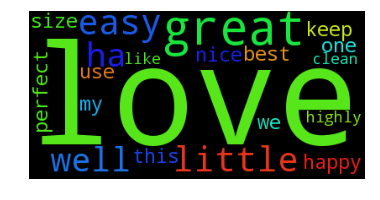

In [48]:
# a partir del listado de tuplas con probabilidades de palabras con sentimiento positivo pintamos su cloudword
# TODO sustituir possitiveData por valor real de Logistic Regression.ipynb#word_coefficient_tuples[0:20]




possitiveData = [('love', 0.11516618684233537),
 ('great', 0.080023721523415775),
 ('easy', 0.060784809521622268),
 ('little', 0.043273114802474026),
 ('well', 0.034577347869094624),
 ('ha', 0.031782657756372915),
 ('perfect', 0.02794323744248348),
 ('keep', 0.024582663611358507),
 ('we', 0.023264533519747128),
 ('my', 0.023145741891859677),
 ('nice', 0.022054081613016238),
 ('use', 0.021768893055755807),
 ('happy', 0.019507169644448902),
 ('this', 0.019297492216305973),
 ('one', 0.018951434854755495),
 ('best', 0.017241315558508198),
 ('size', 0.016596876725228724),
 ('highly', 0.016464206308266966),
 ('like', 0.016012593506922024),
 ('clean', 0.015915941635580182)]
wordcloud = WordCloud(relative_scaling=.1).generate_from_frequencies(possitiveData)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

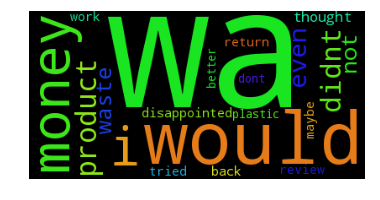

In [49]:
# a partir del listado de tuplas con probabilidades de palabras con sentimiento positivo pintamos su cloudword
# en este caso hay que tener en cuenta que las probabilidades tienen signo negativo por lo que hay que calcular su abs.
# TODO sustituir negativeData por valor real de Logistic Regression.ipynb#word_coefficient_tuples[0:20]
negativeData = [('wa', -0.076910539667272848),
 ('would', -0.047993502855058948),
 ('money', -0.033634663138491436),
 ('i', -0.032149370426236744),
 ('product', -0.031188689049810522),
 ('didnt', -0.03108731671996507),
 ('even', -0.027071648853798525),
 ('not', -0.026410486153495703),
 ('waste', -0.025332366949353691),
 ('thought', -0.021359972210361015),
 ('disappointed', -0.019572581111056395),
 ('review', -0.018478903812761505),
 ('return', -0.018263749740310576),
 ('tried', -0.017464678580141557),
 ('work', -0.017452131489125368),
 ('maybe', -0.016783110263799327),
 ('back', -0.016378378470142032),
 ('plastic', -0.015812374453428448),
 ('better', -0.015453283971803381),
 ('dont', -0.015375793067250303)]
negativeWordsDf = pd.DataFrame(negativeData, columns=['word','probability'])

def absProbability(row):
    return row["probability"].abs()
negativeWordsDf['probability']=absProbability(negativeWordsDf)
negativeData = [tuple(x) for x in negativeWordsDf.values]
wordcloud = WordCloud(relative_scaling=.1).generate_from_frequencies(negativeData)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [50]:
reviews

NameError: name 'reviews' is not defined